In [1]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
from tqdm.auto import tqdm,trange
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from scipy.optimize import fsolve

from DEDlib import *

In [22]:
''' DEDlib is a Distributional Exact Diagonalization tooling library for study of Anderson (multi-)impurity model in Graphene Nanoribbons'''

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import trange
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from numba import njit

class DEDlib(*args):
    N=200000
    poles=4
    U=3
    Sigma=3/2
    Ed=-3/2
    Gamma=0.3
    SizeO=1001
    etaco=[0.02,1e-39]
    ctype='n'
    Edcalc=''
    bound=3
    Tk=[0]
    Nimpurities=1
    U2=0
    J=0
    posb=1

    def __init__(self,*args):

    for arg in args: setattr([name for name, value in globals().items() if value is arg][0], arg)


    print(U)

DEDlib()

NameError: name 'args' is not defined

In [1]:
''' DEDlib is a Distributional Exact Diagonalization tooling library for study of Anderson (multi-)impurity model in Graphene Nanoribbons'''

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import trange
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from numba import njit

class DEDlib:
    def __init__(self,*args):
        self.Nit,self.poles,self.Uimp,self.Sigma,self.Ed,self.Gamma,self.SizeO,self.etaco,self.ctype,self.Edcalc,self.bound,self.Tk,self.Nimpurities,self.U2imp,self.Jimp,self.posb=200000,4,3,3/2,-3/2,0.3,1001,[0.02,1e-39],'n','',3,[0],1,0,0,1
        for arg in args: setattr(self, [name for name, value in globals().items() if value is arg][0], arg)
        self.omega,self.eta,self.selectpcT,self.selectpT,self.Npoles=np.linspace(-self.bound,self.bound,self.SizeO),self.etaco[0]*abs(np.linspace(-self.bound,self.bound,self.SizeO))+self.etaco[1],[],[],int(self.poles/self.Nimpurities)
        self.c,self.pbar=[self.Jordan_wigner_transform(i,2*self.poles) for i in range(2*self.poles)],trange(self.Nit,position=self.posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
        (self.Hn,self.n)=self.Operators(self.c,self.Nimpurities,self.poles)
        self.ndfin,self.NewSigma,self.fDOS,self.Lor,self.tsim=self.main()

    def Jordan_wigner_transform(self,j,lattice_length):
        """Jordan_wigner_transform(j, lattice_length). 
    Defines the Jordan Wigner transformation for a 1D lattice."""
        operators=sigmaz()
        for _ in range(j-1): operators=tensor(operators,sigmaz())
        if j == 0: operators=sigmam()
        else: operators=tensor(operators,sigmam())
        for _ in range(lattice_length - j - 1): operators=tensor(operators,identity(2))
        return operators
    
    def Operators(self,c,Nimpurities,poles):
        posimp=[int(2*poles/Nimpurities*i) for i in range(Nimpurities)]
        impn=[sum([c[posimp[k]+i].dag()*c[posimp[k]+i] for i in range(2)]) for k in range(Nimpurities)]
        bathn=[[sum([c[2*j+i+2+posimp[k]].dag()*c[2*j+i+2+posimp[k]] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
        crossn=[[sum([c[posimp[k]+i].dag()*c[2*j+i+2+posimp[k]]+c[2*j+i+2+posimp[k]].dag()*c[posimp[k]+i] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
        Un=sum([c[posimp[k]].dag()*c[posimp[k]]*c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
        Sigman=sum([c[posimp[k]].dag()*c[posimp[k]]+c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
        U2n=sum([c[posimp[k]+i].dag()*c[posimp[k]+i]*c[posimp[l]+j].dag()*c[posimp[l]+j] for i in range(2) for j in range(2) for l in range(Nimpurities) for k in range(Nimpurities) if k !=l])
        Jn=sum([1/2*(c[posimp[k]].dag()*c[posimp[k]+1]*c[posimp[l]+1].dag()*c[posimp[l]]+c[posimp[k]+1].dag()*c[posimp[k]]*c[posimp[l]].dag()*c[posimp[l]+1])
                        +1/4*(c[posimp[k]].dag()*c[posimp[k]]-c[posimp[k]+1].dag()*c[posimp[k]+1])*(c[posimp[l]].dag()*c[posimp[l]]-c[posimp[l]+1].dag()*c[posimp[l]+1]) for l in range(Nimpurities) for k in range(Nimpurities) if k!=l])
        n=[sum([c[j+posimp[i]].dag()*c[j+posimp[i]] for j in range(2*int(poles/Nimpurities))]) for i in range(Nimpurities)]
        return (impn,bathn,crossn,Un,Sigman,U2n,Jn),n

    def main(self):
        AvgSigmadat,Nfin,nd=np.zeros((len(self.Tk),self.SizeO),dtype='complex_'),np.zeros(len(self.Tk),dtype='float'),np.zeros(len(self.Tk),dtype='complex_')
        while self.pbar.n<self.Nit:
            reset=False
            while not reset:
                NewM,nonG,select=self.Startrans(self.Npoles,np.sort(self.Lorentzian(self.omega,self.Gamma,self.Npoles,self.Ed,self.Sigma)[1]),self.omega,self.eta)
                H0,H=self.HamiltonianAIM(np.repeat(NewM[0][0],self.Nimpurities),np.tile([NewM[k+1][k+1] for k in range(len(NewM)-1)],(self.Nimpurities,1)),np.tile(NewM[0,1:],(self.Nimpurities,1)),self.Uimp,self.Sigma,self.U2imp,self.Jimp,self.Hn)
                try: (MBGdat,Boltzmann,Ev0),reset=self.Constraint(self.ctype,H0,H,self.omega,self.eta,self.c,self.n,self.Tk,np.array([ar<self.Nit for ar in Nfin]))
                except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(self.omega),dtype='complex_'),np.zeros(len(self.Tk)),np.array([])),False
                if np.isnan(1/nonG-1/MBGdat+self.Sigma).any() or np.array([i>=1000 for i in np.real(1/nonG-1/MBGdat+self.Sigma)]).any(): reset=False
                self.selectpT.append(select)
            Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonG-1/MBGdat+self.Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@sum(self.Hn[0]).data.tocoo()@Ev0*Boltzmann
            self.selectpcT.append(select)
            if self.ctype=='sn': self.pbar.n+=1
            else: self.pbar.n=int(min(Nfin))
            self.pbar.refresh()
        self.pbar.close()
        if self.Edcalc == 'AS': return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(self.omega-AvgSigmadat/Nfin[:,None]+(AvgSigmadat[:,int(np.round(self.SizeO/2))]/Nfin)[:,None]+1j*self.Gamma)))/np.pi).squeeze(),self.Lorentzian(self.omega,self.Gamma,self.poles)[0],self.pbar.format_dict["elapsed"]
        else: return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(self.omega-AvgSigmadat/Nfin[:,None]-self.Ed+1j*self.Gamma)))/np.pi).squeeze(),self.Lorentzian(self.omega,self.Gamma,self.poles,self.Ed,self.Sigma)[0],self.pbar.format_dict["elapsed"]

    #@njit
    def Lorentzian(self,omega,Gamma,poles,Ed=-3/2,Sigma=3/2):
        """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
    Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
        return -np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi,np.array([Gamma*np.tan(np.pi*(pi-1/2))+Ed+Sigma for pi in np.random.uniform(0,1,poles)])

    #@njit
    def Startrans(self,poles,select,omega,eta,row=0):
        """Startrans(poles,select,row,omega, eta). 
    Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
        Pbath,Dbath,pbar,G=np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros(omega.shape,dtype='complex_')
        for i in range(poles-1):
            for j in range(poles-1):
                if j>=i: Pbath[i+1][j+1]=-1/np.sqrt((poles-i-1)*(poles-i))
            Pbath[i+1][i]=np.sqrt(poles-i-1)/np.sqrt(poles-i)
        Pbath[row,:]=1/np.sqrt(poles)
        for i, _ in enumerate(select): Dbath[i][i]=select[i]
        pbar[1:,1:]=np.linalg.eig((Pbath@Dbath@Pbath.T)[1:,1:])[1]
        pbar[row][row]=1
        for i, _ in enumerate(select): G+=1/len(select)/(omega-select[i]+1.j*eta)
        return pbar.T@Pbath@Dbath@Pbath.T@pbar,G,select
    
    def HamiltonianAIM(self,impenergy,bathenergy,Vkk,U,Sigma,U2,J,Hn,H0=0):
        """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
    Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
        for k in range(len(impenergy)):
            H0+=impenergy[k]*Hn[0][k]
            for j in range(len(bathenergy[k])): H0+=bathenergy[k][j]*Hn[1][k][j]+Vkk[k][j]*Hn[2][k][j]
        return H0,H0+U*Hn[3]-Sigma*Hn[4]+(U2/2-J/4)*Hn[5]-J*Hn[6]
    
    def Constraint(self,ctype,H0,H,omega,eta,c,n,Tk,Nfin):
        """Constraint(ctype,H0,H,omega,eta,c,n). 
    Constraint implementation function for DED method with various possible constraints."""
        if ctype[0]=='m':
            vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                            scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
            exp=np.conj(vecs)@n[0].data@vecs.T
            if ctype=='mosn' and np.round(exp[0,0])==np.round(exp[1,1]):
                return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
            else:
                return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
        elif ctype[0]=='s':
            vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0]
            evals,evecs=scipy.linalg.eigh(H.data.toarray())
            if ctype=='ssn':
                Boltzmann=np.exp(-abs(evals[self.find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
                return self.MBGAIM(omega,H,c,eta,Tk,Boltzmann,evals,evecs,4e-4,np.array([-2,-1,0,1,2])),True
            else:
                return self.MBGAIM(omega,H,c,eta,Tk,np.exp(-abs(evals[self.find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk),evals,evecs,4e-4,np.array([-2,-1,0,1,2])),True
        elif ctype[0]=='n':
            vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                                    scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
            exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
            if ctype=='n%2' and all([int(np.round(expi[0,0]))%2==int(np.round(expi[1,1]))%2 for expi in exp]):
                return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
            elif ctype=='n' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
                return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
            else:
                return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
        elif ctype[0]=='d':
            vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0,0])[1][:,0],
                                                    scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0])))
            exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
            if ctype=='dn' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
                return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
            else:
                return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
        else:
            return self.MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        
    def MBGAIM(self,omega,H,c,eta,Tk,Boltzmann,evals=[],evecs=[],etaoffset=1e-4,posoffset=np.zeros(1,dtype='int')):
        """MBGAIM(omega, H, c, eta). 
    Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
        if ~np.any(evals): evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if Tk==[0]:
            vecn=np.conj(evecs[:,1:]).T
            exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
            return self.MBGT0(omega,eta,evals,exp,exp2),Boltzmann,evecs[:,0]
        else:
            MGdat,eta[int(np.round(len(eta)/2))+posoffset]=np.ones((len(Tk),len(omega)),dtype='complex_'),etaoffset
            for k,T in enumerate(Tk):
                if Boltzmann[k]!=0:
                    eevals,vecn=np.exp(-evals/T-scipy.special.logsumexp(-evals/T)),np.conj(evecs).T
                    exp,exp2=vecn@c[0].data.tocoo()@evecs,vecn@c[0].dag().data.tocoo()@evecs
                    MGdat[k,:]=self.MBGTnonzero(omega,eta,evals,exp,exp2,eevals)
            return MGdat.squeeze(),Boltzmann,evecs[:,0]
        
    #@njit
    def MBGT0(self,omega,eta,evals,exp,exp2):
        G=np.zeros(len(omega),dtype='complex_')
        for i,expi in enumerate(exp): G+=abs(expi)**2/(omega+evals[i+1]-evals[0]+1.j*eta)+abs(exp2[i])**2/(omega+evals[0]-evals[i+1]+1.j*eta)
        return G

    #@njit
    def MBGTnonzero(self,omega,eta,evals,exp,exp2,eevals):
        G=np.zeros(len(omega),dtype='complex_')
        for i,evi in enumerate(evals):
            for j,evj in enumerate(evals):
                G+=(exp[i][j]*exp2[j][i]/(omega+evi-evj+1.j*eta)+exp[j][i]*exp2[i][j]/(omega+evj-evi+1.j*eta))*eevals[i]
        return G
    
    def find_nearest(self,array,value):
        for i in (i for i,arrval in enumerate(array) if np.isclose(arrval,value,atol=0.1)): return i

    def DOSplot(self,name,labels,log=False,ymax=1.2):
        """DOSplot(fDOS,Lor,omega,name,labels). 
    A plot function to present results from the AIM moddeling for a single results with a comparison to the non-interacting DOS."""
        plt.figure(figsize=(10,8))
        plt.rc('legend',fontsize=17)
        plt.rc('font',size=25)
        plt.rc('xtick',labelsize=25)
        plt.rc('ytick',labelsize=25)
        axis_font={'fontname':'Calibri','size':'25'}
        plt.xlim(min(self.omega),max(self.omega))
        if not log:
            plt.gca().set_ylim(bottom=0,top=ymax)
            plt.gca().set_xticks(np.linspace(min(self.omega),max(self.omega),2*int(max(self.omega))+1),minor=False)
        else: 
            plt.yscale('log')
            plt.gca().set_ylim(bottom=0.0001,top=10)
            plt.gca().set_xticks([-8,-6,-4,-2,0,2,4,6,8],minor=False)
        plt.xlabel("$\\omega$ [-]",**axis_font)
        plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom",rotation=0,labelpad=30,**axis_font)
        plt.plot(self.omega,self.Lor,'--r',linewidth=4,label='$\\rho_0$')
        plt.plot(self.omega,self.fDOS,'-b',label=labels)
        plt.legend(fancybox=False).get_frame().set_edgecolor('black')
        plt.grid()
        plt.tight_layout()
        #plt.savefig(name+'.png',format='png')
        #plt.savefig(name+'.svg',format='svg',dpi=3600)
        plt.draw()
        plt.pause(5)
        plt.close()
        return plt


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import trange
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from numba import njit

#class DED:

def Jordan_wigner_transform(j,lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators=sigmaz()
    for _ in range(j-1): operators=tensor(operators,sigmaz())
    if j == 0: operators=sigmam()
    else: operators=tensor(operators,sigmam())
    for _ in range(lattice_length - j - 1): operators=tensor(operators,identity(2))
    return operators

@njit
def Lorentzian(omega,Gamma,poles,Ed=-3/2,Sigma=3/2):
    """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
    return -np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi,np.array([Gamma*np.tan(np.pi*(pi-1/2))+Ed+Sigma for pi in np.random.uniform(0,1,poles)])

@njit
def Startrans(poles,select,omega,eta,row=0):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    Pbath,Dbath,pbar,G=np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros((poles,poles)),np.zeros(omega.shape,dtype='complex_')
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i: Pbath[i+1][j+1]=-1/np.sqrt((poles-i-1)*(poles-i))
        Pbath[i+1][i]=np.sqrt(poles-i-1)/np.sqrt(poles-i)
    Pbath[row,:]=1/np.sqrt(poles)
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    pbar[1:,1:]=np.linalg.eig((Pbath@Dbath@Pbath.T)[1:,1:])[1]
    pbar[row][row]=1
    for i, _ in enumerate(select): G+=1/len(select)/(omega-select[i]+1.j*eta)
    return pbar.T@Pbath@Dbath@Pbath.T@pbar,G,select

def Operators(c,Nimpurities,poles):
    posimp=[int(2*poles/Nimpurities*i) for i in range(Nimpurities)]
    impn=[sum([c[posimp[k]+i].dag()*c[posimp[k]+i] for i in range(2)]) for k in range(Nimpurities)]
    bathn=[[sum([c[2*j+i+2+posimp[k]].dag()*c[2*j+i+2+posimp[k]] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
    crossn=[[sum([c[posimp[k]+i].dag()*c[2*j+i+2+posimp[k]]+c[2*j+i+2+posimp[k]].dag()*c[posimp[k]+i] for i in range(2)]) for j in range(int(poles/Nimpurities)-1)] for k in range(Nimpurities)]
    Un=sum([c[posimp[k]].dag()*c[posimp[k]]*c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
    Sigman=sum([c[posimp[k]].dag()*c[posimp[k]]+c[posimp[k]+1].dag()*c[posimp[k]+1] for k in range(Nimpurities)])
    U2n=sum([c[posimp[k]+i].dag()*c[posimp[k]+i]*c[posimp[l]+j].dag()*c[posimp[l]+j] for i in range(2) for j in range(2) for l in range(Nimpurities) for k in range(Nimpurities) if k !=l])
    Jn=sum([1/2*(c[posimp[k]].dag()*c[posimp[k]+1]*c[posimp[l]+1].dag()*c[posimp[l]]+c[posimp[k]+1].dag()*c[posimp[k]]*c[posimp[l]].dag()*c[posimp[l]+1])
                    +1/4*(c[posimp[k]].dag()*c[posimp[k]]-c[posimp[k]+1].dag()*c[posimp[k]+1])*(c[posimp[l]].dag()*c[posimp[l]]-c[posimp[l]+1].dag()*c[posimp[l]+1]) for l in range(Nimpurities) for k in range(Nimpurities) if k!=l])
    n=[sum([c[j+posimp[i]].dag()*c[j+posimp[i]] for j in range(2*int(poles/Nimpurities))]) for i in range(Nimpurities)]
    return (impn,bathn,crossn,Un,Sigman,U2n,Jn),n

def HamiltonianAIM(impenergy,bathenergy,Vkk,U,Sigma,U2,J,Hn,H0=0):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    for k in range(len(impenergy)):
        H0+=impenergy[k]*Hn[0][k]
        for j in range(len(bathenergy[k])): H0+=bathenergy[k][j]*Hn[1][k][j]+Vkk[k][j]*Hn[2][k][j]
    return H0,H0+U*Hn[3]-Sigma*Hn[4]+(U2/2-J/4)*Hn[5]-J*Hn[6]

@njit
def MBGT0(omega,eta,evals,exp,exp2):
    G=np.zeros(len(omega),dtype='complex_')
    for i,expi in enumerate(exp): G+=abs(expi)**2/(omega+evals[i+1]-evals[0]+1.j*eta)+abs(exp2[i])**2/(omega+evals[0]-evals[i+1]+1.j*eta)
    return G

@njit
def MBGTnonzero(omega,eta,evals,exp,exp2,eevals):
    G=np.zeros(len(omega),dtype='complex_')
    for i,evi in enumerate(evals):
        for j,evj in enumerate(evals):
            G+=(exp[i][j]*exp2[j][i]/(omega+evi-evj+1.j*eta)+exp[j][i]*exp2[i][j]/(omega+evj-evi+1.j*eta))*eevals[i]
    return G

def MBGAIM(omega,H,c,eta,Tk,Boltzmann,evals=[],evecs=[],etaoffset=1e-4,posoffset=np.zeros(1,dtype='int')):
    """MBGAIM(omega, H, c, eta). 
Calculates the many body Green's function based on the Hamiltonian eigenenergies/-states."""
    if ~np.any(evals): evals,evecs=scipy.linalg.eigh(H.data.toarray())
    if Tk==[0]:
        vecn=np.conj(evecs[:,1:]).T
        exp,exp2=vecn@c[0].data.tocoo()@evecs[:,0],vecn@c[0].dag().data.tocoo()@evecs[:,0]
        return MBGT0(omega,eta,evals,exp,exp2),Boltzmann,evecs[:,0]
    else:
        MGdat,eta[int(np.round(len(eta)/2))+posoffset]=np.ones((len(Tk),len(omega)),dtype='complex_'),etaoffset
        for k,T in enumerate(Tk):
            if Boltzmann[k]!=0:
                eevals,vecn=np.exp(-evals/T-scipy.special.logsumexp(-evals/T)),np.conj(evecs).T
                exp,exp2=vecn@c[0].data.tocoo()@evecs,vecn@c[0].dag().data.tocoo()@evecs
                MGdat[k,:]=MBGTnonzero(omega,eta,evals,exp,exp2,eevals)
        return MGdat.squeeze(),Boltzmann,evecs[:,0]

def Constraint(ctype,H0,H,omega,eta,c,n,Tk,Nfin):
    """Constraint(ctype,H0,H,omega,eta,c,n). 
Constraint implementation function for DED method with various possible constraints."""
    if ctype[0]=='m':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                        scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
        exp=np.conj(vecs)@n[0].data@vecs.T
        if ctype=='mosn' and np.round(exp[0,0])==np.round(exp[1,1]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    elif ctype[0]=='s':
        vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0]
        evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if ctype=='ssn':
            Boltzmann=np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
            return MBGAIM(omega,H,c,eta,Tk,Boltzmann,evals,evecs,4e-4,np.array([-2,-1,0,1,2])),True
        else:
            return MBGAIM(omega,H,c,eta,Tk,np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n[0].data@evecs),np.conj(vecs)@n[0].data@vecs.T)]-evals[0])/Tk),evals,evecs,4e-4,np.array([-2,-1,0,1,2])),True
    elif ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data),k=1,which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data),k=1,which='SA')[1][:,0])))
        exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
        if ctype=='n%2' and all([int(np.round(expi[0,0]))%2==int(np.round(expi[1,1]))%2 for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        elif ctype=='n' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    elif ctype[0]=='d':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0,0])[1][:,0],
                                                scipy.linalg.eigh(H0.data.toarray(),eigvals=[0,0])[1][:,0])))
        exp=[np.conj(vecs)@ni.data@vecs.T for ni in n]
        if ctype=='dn' and all([np.round(expi[0,0])==np.round(expi[1,1]) for expi in exp]):
            return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
        else:
            return (np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
    else:
        return MBGAIM(omega,H,c,eta,Tk,np.ones(len(Tk))),True
    
def find_nearest(array,value):
    for i in (i for i,arrval in enumerate(array) if np.isclose(arrval,value,atol=0.1)): return i

def main(N=200000,poles=4,U=3,Sigma=3/2,Ed=-3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39],ctype='n',Edcalc='',bound=3,Tk=[0],Nimpurities=1,U2=0,J=0,posb=1,log=False,base=1.5):
    """main(N=1000000,poles=4,U=3,Sigma=3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39], ctype='n',Ed='AS'). 
The main DED function simulating the Anderson impurity model for given parameters."""
    if log: omega,selectpcT,selectpT,Npoles=np.concatenate((-np.logspace(np.log(bound)/np.log(base),-40,int(np.round(SizeO/2)),base=base),np.logspace(-40,np.log(bound)/np.log(base),int(np.round(SizeO/2)),base=base))),[],[],int(poles/Nimpurities)
    else: omega,selectpcT,selectpT,Npoles=np.linspace(-bound,bound,SizeO),[],[],int(poles/Nimpurities)
    c,pbar,eta=[Jordan_wigner_transform(i,2*poles) for i in range(2*poles)],trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'),etaco[0]*abs(omega)+etaco[1]
    (Hn,n),AvgSigmadat,Nfin,nd=Operators(c,Nimpurities,poles),np.zeros((len(Tk),SizeO),dtype='complex_'),np.zeros(len(Tk),dtype='float'),np.zeros(len(Tk),dtype='complex_')
    while pbar.n<N:
        reset=False
        while not reset:
            NewM,nonG,select=Startrans(Npoles,np.sort(Lorentzian(omega,Gamma,Npoles,Ed,Sigma)[1]),omega,eta)
            H0,H=HamiltonianAIM(np.repeat(NewM[0][0],Nimpurities),np.tile([NewM[k+1][k+1] for k in range(len(NewM)-1)],(Nimpurities,1)),np.tile(NewM[0,1:],(Nimpurities,1)),U,Sigma,U2,J,Hn)
            try: (MBGdat,Boltzmann,Ev0),reset=Constraint(ctype,H0,H,omega,eta,c,n,Tk,np.array([ar<N for ar in Nfin]))
            except (np.linalg.LinAlgError,ValueError,scipy.sparse.linalg.ArpackNoConvergence): (MBGdat,Boltzmann,Ev0),reset=(np.zeros(len(omega),dtype='complex_'),np.zeros(len(Tk)),np.array([])),False
            if np.isnan(1/nonG-1/MBGdat+Sigma).any() or np.array([i>=1000 for i in np.real(1/nonG-1/MBGdat+Sigma)]).any(): reset=False
            selectpT.append(select)
        Nfin,AvgSigmadat,nd=Nfin+Boltzmann,AvgSigmadat+(1/nonG-1/MBGdat+Sigma)*Boltzmann[:,None],nd+np.conj(Ev0).T@sum(Hn[0]).data.tocoo()@Ev0*Boltzmann
        selectpcT.append(select)
        if ctype=='sn': pbar.n+=1
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    if Edcalc == 'AS': return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]+(AvgSigmadat[:,int(np.round(SizeO/2))]/Nfin)[:,None]+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]
    else: return (Nfin.squeeze(),np.real(nd/Nfin).squeeze()),(AvgSigmadat/Nfin[:,None]).squeeze(),(-np.imag(np.nan_to_num(1/(omega-AvgSigmadat/Nfin[:,None]-Ed+1j*Gamma)))/np.pi).squeeze(),Lorentzian(omega,Gamma,poles,Ed,Sigma)[0],omega,selectpT,selectpcT,pbar.format_dict["elapsed"]

def DOSplot(fDOS,Lor,omega,name,labels,log=False,ymax=1.2,save=True):
    """DOSplot(fDOS,Lor,omega,name,labels). 
A plot function to present results from the AIM moddeling for a single results with a comparison to the non-interacting DOS."""
    plt.figure(figsize=(10,8))
    plt.rc('legend',fontsize=17)
    plt.rc('font',size=25)
    plt.rc('xtick',labelsize=25)
    plt.rc('ytick',labelsize=25)
    axis_font={'fontname':'Calibri','size':'25'}
    plt.xlim(min(omega),max(omega))
    if not log:
        plt.gca().set_ylim(bottom=0,top=ymax)
        plt.gca().set_xticks(np.linspace(min(omega),max(omega),2*int(max(omega))+1),minor=False)
    else: 
        plt.yscale('log')
        plt.gca().set_ylim(bottom=0.0001,top=10)
        plt.gca().set_xticks([-8,-6,-4,-2,0,2,4,6,8],minor=False)
    plt.xlabel("$\\omega$ [-]",**axis_font)
    plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom",rotation=0,labelpad=30,**axis_font)
    plt.plot(omega,Lor,'--r',linewidth=4,label='$\\rho_0$')
    plt.plot(omega,fDOS,'-b',label=labels)
    plt.legend(fancybox=False).get_frame().set_edgecolor('black')
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(name+'.png',format='png')
        plt.savefig(name+'.svg',format='svg',dpi=3600)
    plt.draw()
    plt.pause(5)
    plt.close()
    return plt

In [ ]:
nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=main(**{"N":2000,"poles":2,"Ed":-3/2,"SizeO":20000,"ctype":'n',"log":True})
DOSplot(fDOS,Lor,omega,'constraintN2p','$\\rho_{constr.},N,$n=2')

Iterations:   0%|          | 0/200000 [00:00<?, ?it/s]

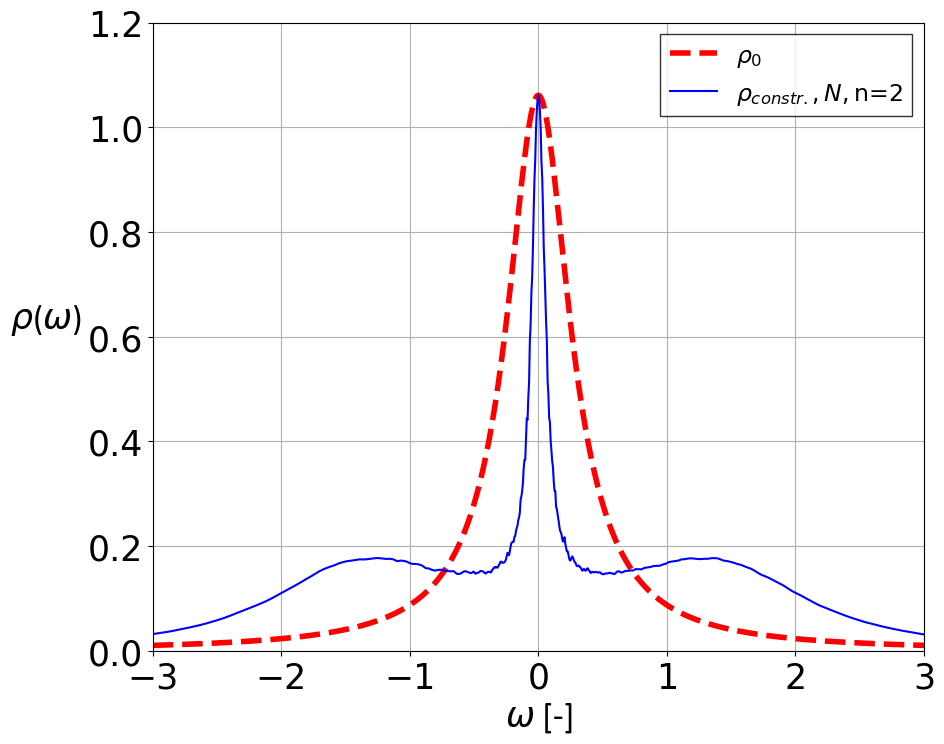

In [2]:
poles,Nit=2,200000
test=DEDlib(poles,Nit)
test.Nit
name,labels='constraintN2p','$\\rho_{constr.},N,$n=2'
plot=test.DOSplot(name,labels)

Iterations:   0%|          | 0/4000000 [00:00<?, ?it/s]

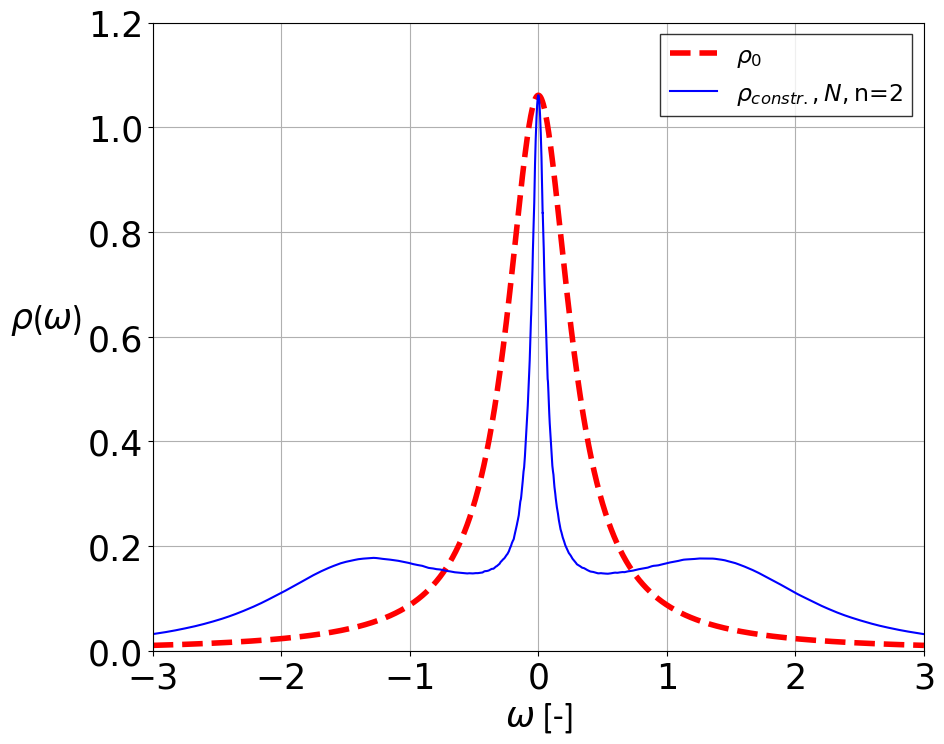

NameError: name 'np' is not defined

In [1]:
import DEDlib

nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=DEDlib.main(**{"N":4000000,"poles":2,"Ed":-3/2,"SizeO":20000,"ctype":'n',"log":True})
DEDlib.DOSplot(fDOS,Lor,omega,'constraintN2plog','$\\rho_{constr.},N,$n=2')
DEDlib.textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),fDOS,'constraintN2plog')

In [2]:
import numpy as np
DEDlib.textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),fDOS,'constraintN2plog')

Iterations:   0%|          | 0/4000000 [00:00<?, ?it/s]

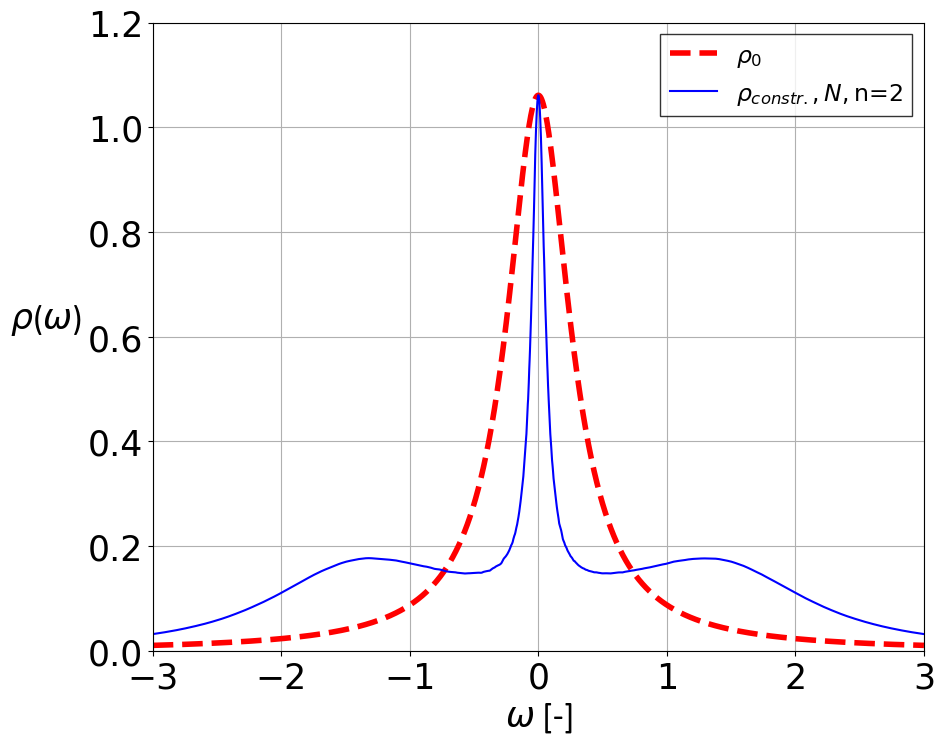

In [1]:
import DEDlib
import numpy as np

nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=DEDlib.main(**{"N":4000000,"poles":2,"Ed":-3/2,"SizeO":12800,"ctype":'n',"log":True})
DEDlib.DOSplot(fDOS,Lor,omega,'constraintN2ploge-5','$\\rho_{constr.},N,$n=2')
DEDlib.textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),fDOS,'constraintN2ploge-5')

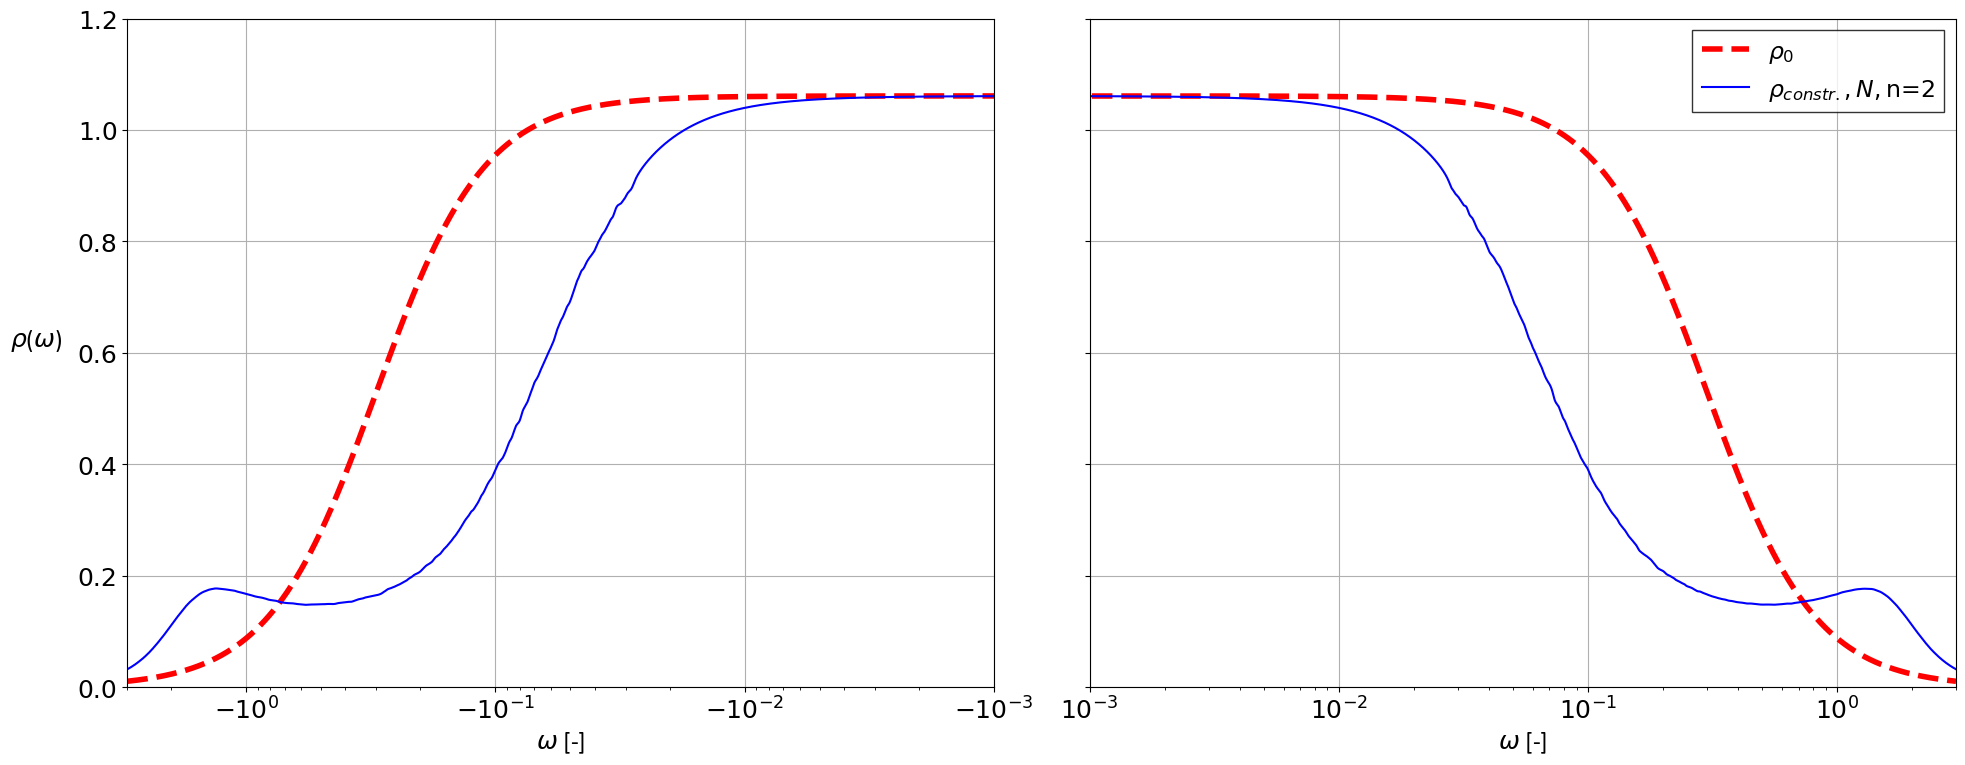

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [2]:
DEDlib.DOSxlogplot(fDOS,Lor,omega,'constraintN2ploge-5logx','$\\rho_{constr.},N,$n=2')

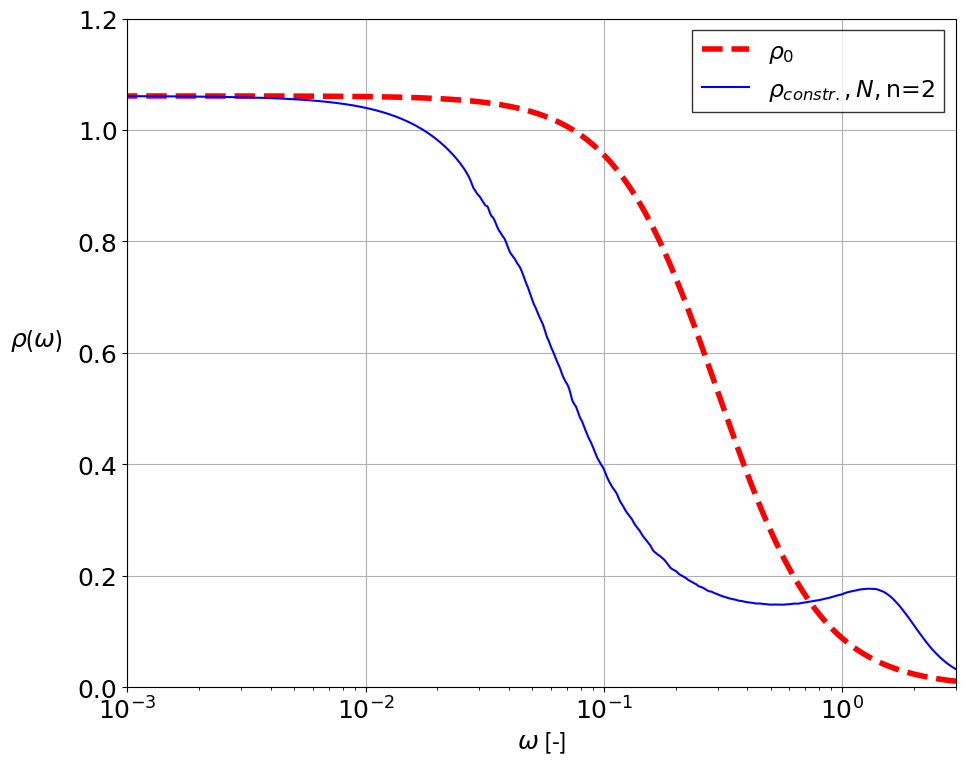

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [3]:
DEDlib.DOSxlogplot(fDOS,Lor,omega,'constraintN2ploge-5logxpos','$\\rho_{constr.},N,$n=2',incneg=False)

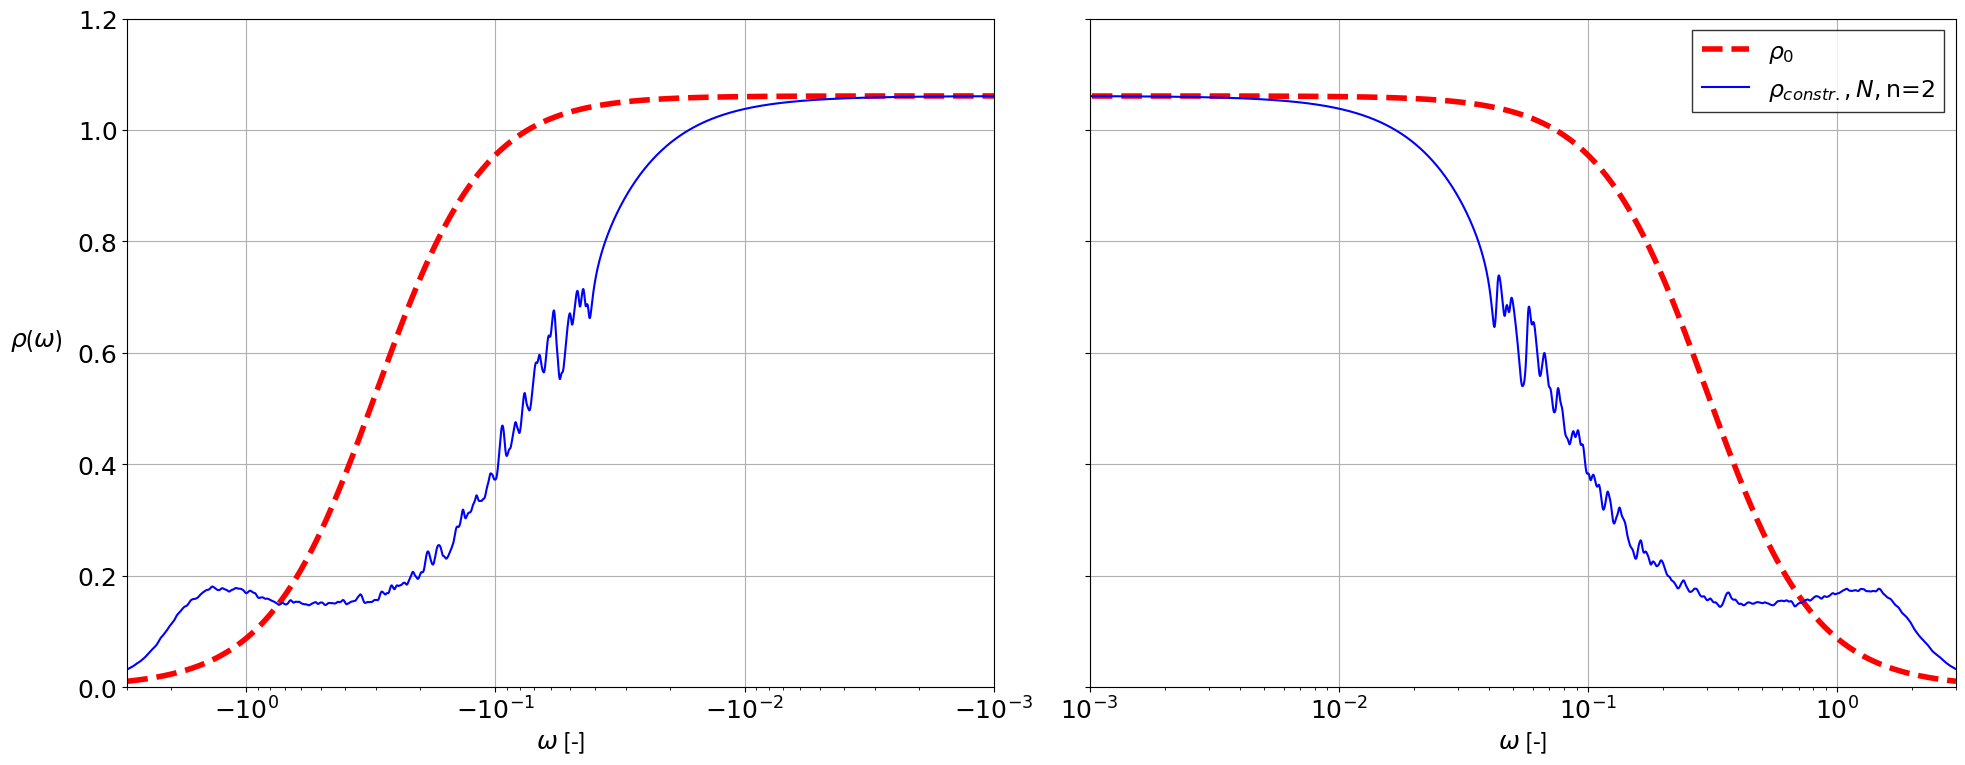

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from numba import njit

from matplotlib.ticker import FuncFormatter

def DOSplot(fDOS,Lor,omega,name,labels,log=False,ymax=1.2,save=True,xlog=False,xloglim=1e-3):
    """DOSplot(fDOS,Lor,omega,name,labels). 
A plot function to present results from the AIM moddeling for a single results with a comparison to the non-interacting DOS."""
    fig=plt.figure(figsize=(20,8))
    #plt.rc('legend',fontsize=17)
    #plt.rc('font',size=25)
    #plt.rc('xtick',labelsize=25)
    #plt.rc('ytick',labelsize=25)
    axis_font={'fontname':'Calibri','size':'18'}

    if xlog:
        plt.rc('legend',fontsize=17)
        plt.rc('font',size=18)
        plt.rc('xtick',labelsize=18)
        plt.rc('ytick',labelsize=18)
        #plt.rcParams["figure.figsize"] = (20,8)
        #fig.figure.figsize(20,8)
        #fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        #plt.xscale('symlog')
        #plt.gca().set_xlim(left=3,right=1e-5)
        #print(-omega[:len(omega)//2])
        #plt.gca().set_xlim(left=3,right=1e-5)
        #plt.gca().set_xlim(left=xloglim,right=3)
        ax1.set_ylabel("$\\rho$($\\omega$)",va="bottom",rotation=0,labelpad=30,**axis_font)
        ax1.set_xscale('log')
        ax1.invert_xaxis()
        #ax1.axis([-3,1e-5,0,ymax])
        ax1.set_xticks([1,1e-1,1e-2,1e-3,1e-4,1e-5])
        ax1.set_xlim(max(omega),xloglim)
        ax1.set_ylim(0,ymax)
        #plt.gca().set_xlim(left=1e-5,right=3)
        ax1.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: '$-\\mathdefault{10^{'+f'{int(np.log10(x))}'+'}}$'))


        ax1.plot(-omega[:len(omega)//2],Lor[:len(omega)//2],'--r',linewidth=4,label='$\\rho_0$')
        ax1.plot(-omega[:len(omega)//2],fDOS[:len(omega)//2],'-b',label=labels)
        
        ax2.set_xlim(xloglim,max(omega))
        ax2.set_ylim(0,ymax)
        ax2.set_xscale('log')
        ax2.yaxis.set_tick_params(labelleft=False)
        
        ax2.plot(omega[len(omega)//2:],Lor[len(omega)//2:],'--r',linewidth=4,label='$\\rho_0$')
        ax2.plot(omega[len(omega)//2:],fDOS[len(omega)//2:],'-b',label=labels)

        ax1.grid()
        ax2.grid()
        ax1.set_xlabel("$\\omega$ [-]",**axis_font)
        ax2.set_xlabel("$\\omega$ [-]",**axis_font)

        #plt.gca().set_ylim(bottom=0,top=ymax)

    else:
        plt.xlim(min(omega),max(omega))
        if not log:
            plt.gca().set_ylim(bottom=0,top=ymax)
            plt.gca().set_xticks(np.linspace(min(omega),max(omega),2*int(max(omega))+1),minor=False)
        else: 
            plt.yscale('log')
            plt.gca().set_ylim(bottom=0.0001,top=10)
            plt.gca().set_xticks([-8,-6,-4,-2,0,2,4,6,8],minor=False)
        plt.plot(omega,Lor,'--r',linewidth=4,label='$\\rho_0$')
        plt.plot(omega,fDOS,'-b',label=labels)


    #plt.xlabel("$\\omega$ [-]",**axis_font)
    #plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom",rotation=0,labelpad=30,**axis_font)
    plt.legend(fancybox=False).get_frame().set_edgecolor('black')
    #plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig(name+'.png',format='png')
        plt.savefig(name+'.svg',format='svg',dpi=3600)
    plt.draw()
    plt.pause(5)
    plt.close()
    return plt

DOSplot(fDOS,Lor,omega,'constraintN2plog','$\\rho_{constr.},N,$n=2',save=True,xlog=True)

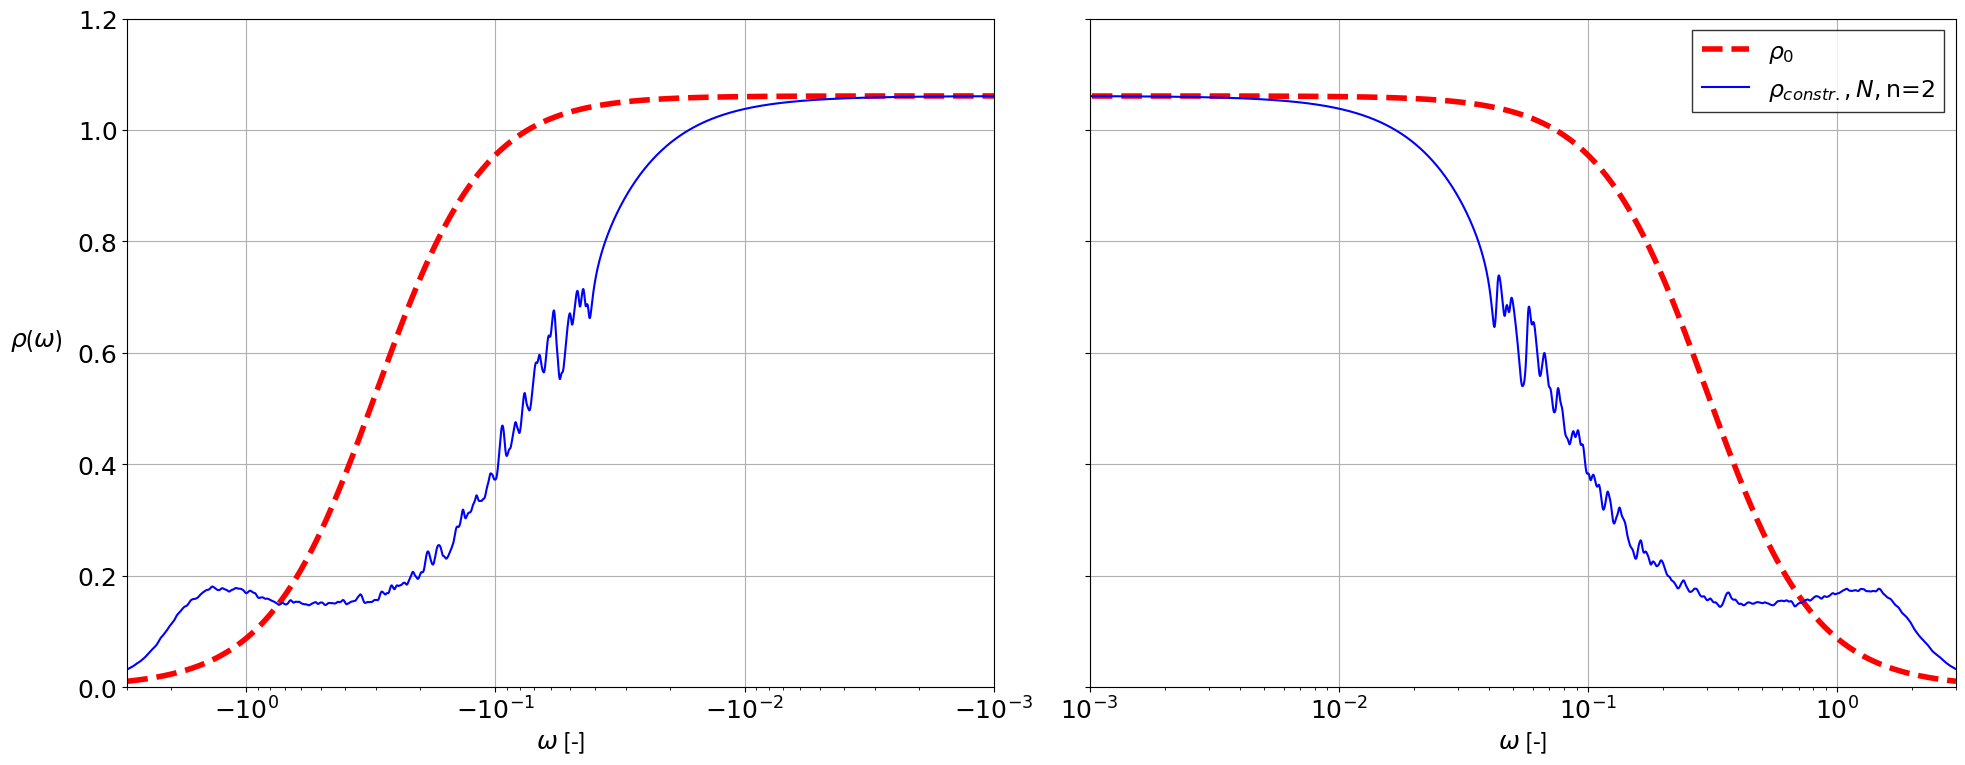

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [149]:
def DOSxlogplot(fDOS,Lor,omega,name,labels,ymax=1.2,save=True,xloglim=1e-3,incneg=True):
    fig=plt.figure(figsize=(10+incneg*10,8))
    plt.rc('legend',fontsize=17)
    plt.rc('font',size=18)
    plt.rc('xtick',labelsize=18)
    plt.rc('ytick',labelsize=18)
    axis_font={'fontname':'Calibri','size':'18'}
    if incneg:
        ax1=fig.add_subplot(121)
        ax2=fig.add_subplot(122)
        ax1.set_ylabel("$\\rho$($\\omega$)",va="bottom",rotation=0,labelpad=30,**axis_font)
        ax1.set_xscale('log')
        ax1.invert_xaxis()
        ax1.set_xticks([1,1e-1,1e-2,1e-3,1e-4,1e-5])
        ax1.set_xlim(max(omega),xloglim)
        ax1.set_ylim(0,ymax)
        ax1.xaxis.set_major_formatter(FuncFormatter(lambda x,pos: '$-\\mathdefault{10^{'+f'{int(np.log10(x))}'+'}}$'))
        ax1.plot(-omega[:len(omega)//2],Lor[:len(omega)//2],'--r',linewidth=4,label='$\\rho_0$')
        ax1.plot(-omega[:len(omega)//2],fDOS[:len(omega)//2],'-b',label=labels)
        ax2.set_xlim(xloglim,max(omega))
        ax2.set_xscale('log')
        ax2.set_ylim(0,ymax)
        ax2.yaxis.set_tick_params(labelleft=False)
        ax2.plot(omega[len(omega)//2:],Lor[len(omega)//2:],'--r',linewidth=4,label='$\\rho_0$')
        ax2.plot(omega[len(omega)//2:],fDOS[len(omega)//2:],'-b',label=labels)
        ax1.grid()
        ax2.grid()
        ax1.set_xlabel("$\\omega$ [-]",**axis_font)
        ax2.set_xlabel("$\\omega$ [-]",**axis_font)
    else:
        plt.xscale('log')
        plt.gca().set_xticks([1,1e-1,1e-2,1e-3,1e-4,1e-5],minor=False)
        plt.gca().set_xlim(xloglim,max(omega))
        plt.gca().set_ylim(bottom=0,top=ymax)
        plt.xlabel("$\\omega$ [-]",**axis_font)
        plt.gca().set_ylabel("$\\rho$($\\omega$)",va="bottom",rotation=0,labelpad=30,**axis_font)
        plt.plot(omega[len(omega)//2:],Lor[len(omega)//2:],'--r',linewidth=4,label='$\\rho_0$')
        plt.plot(omega[len(omega)//2:],fDOS[len(omega)//2:],'-b',label=labels)
        plt.grid()
    plt.legend(fancybox=False).get_frame().set_edgecolor('black')
    plt.tight_layout()
    if save:
        plt.savefig(name+'.png',format='png')
        plt.savefig(name+'.svg',format='svg',dpi=3600)
    plt.draw()
    plt.pause(5)
    plt.close()
    return plt

DOSxlogplot(fDOS,Lor,omega,'constraintN2plog','$\\rho_{constr.},N,$n=2',save=False)

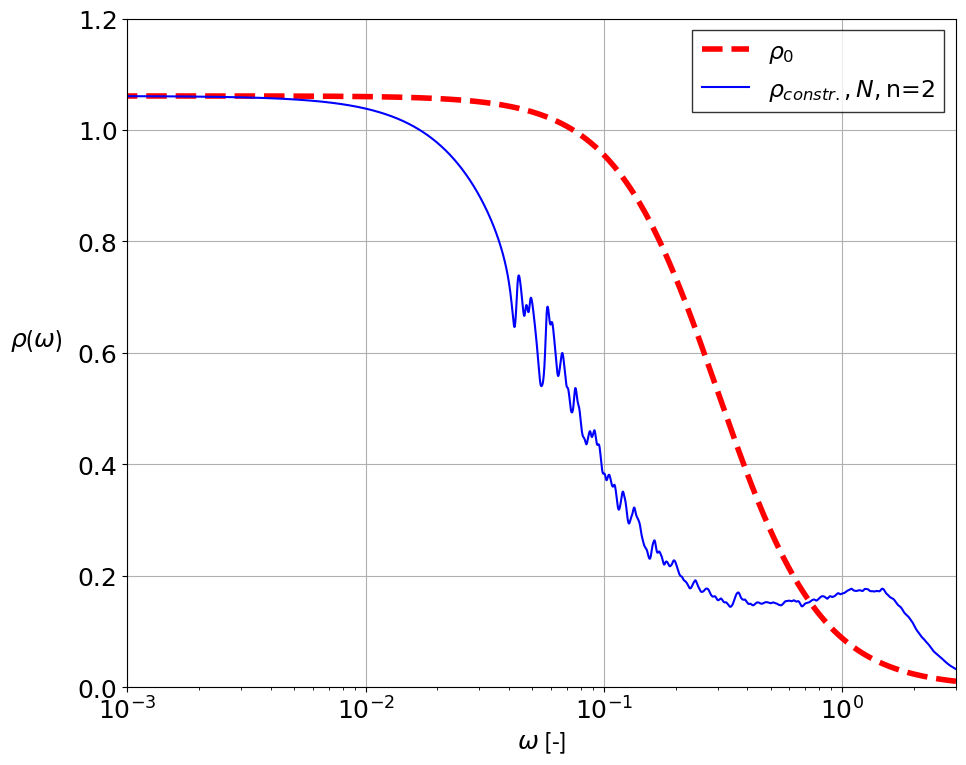

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [150]:
DOSxlogplot(fDOS,Lor,omega,'constraintN2plog','$\\rho_{constr.},N,$n=2',save=False,incneg=False)

In [4]:
base=1.5
bound=3
SizeO=20000
omega=np.logspace(-40,np.log(bound)/np.log(base),int(np.round(SizeO/2)),base=base)

In [63]:
SizeO=12700

In [72]:
SizeO=10000

In [43]:
np.log(10**(-5))/np.log(1.5)

-28.394367936337865

In [77]:
pow=np.log(1e-5)/np.log(base)#-34.07324152360543682767295643337023381574901749856052225228
omeganew=np.logspace(pow,np.log(bound)/np.log(base),int(np.round(SizeO/2)),base=base)

In [79]:
pow

-28.394367936337865

In [81]:
omeganew

array([1.00000000e-05, 1.00252600e-05, 1.00505837e-05, ...,
       2.98490125e+00, 2.99244110e+00, 3.00000000e+00])

In [80]:
omeganew[-20: ]

array([2.85959172, 2.86681504, 2.8740566 , 2.88131646, 2.88859466,
       2.89589124, 2.90320625, 2.91053974, 2.91789176, 2.92526235,
       2.93265155, 2.94005942, 2.947486  , 2.95493134, 2.96239549,
       2.96987849, 2.9773804 , 2.98490125, 2.9924411 , 3.        ])

In [5]:
omega

array([9.04377268e-08, 9.05944912e-08, 9.07515273e-08, ...,
       2.98962661e+00, 2.99480881e+00, 3.00000000e+00])

In [1]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
from tqdm.auto import tqdm,trange
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from scipy.optimize import fsolve

import DEDlib

nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=DEDlib.main(**{"N":4000000,"poles":4,"Ed":-3/2,"ctype":'n'})
DEDlib.DOSplot(fDOS,Lor,omega,'constraintN4p','$\\rho_{constr.},N,$n=4')
DEDlib.textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),fDOS,'constraintN4p',savpoles=False)

Iterations:   0%|          | 0/4000000 [00:00<?, ?it/s]

Iterations:   0%|          | 0/4000000 [00:00<?, ?it/s]

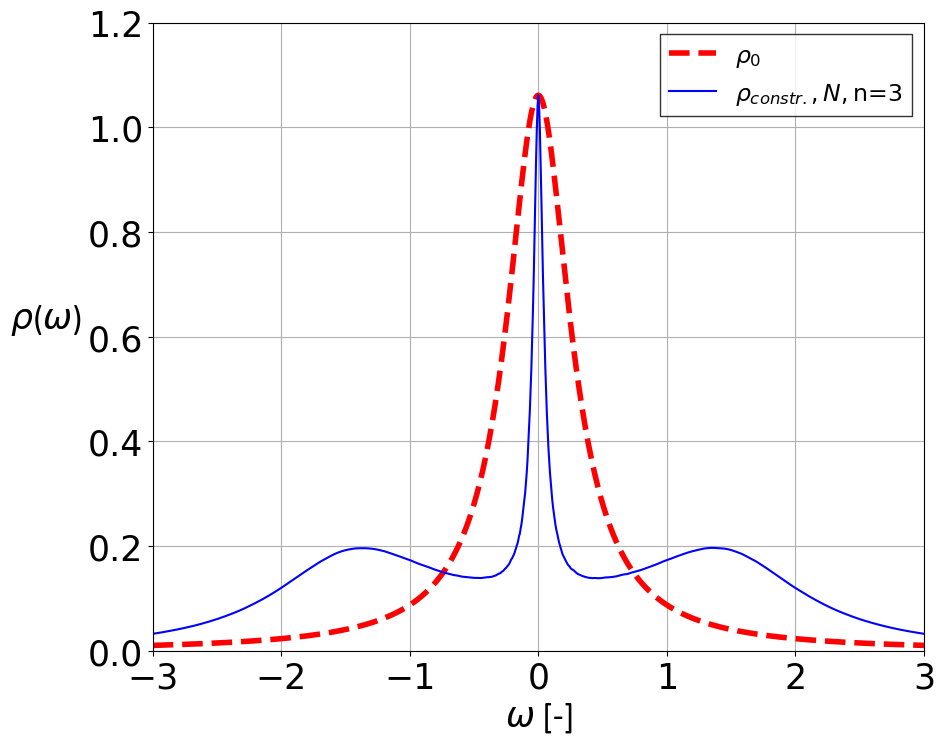

In [1]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
from tqdm.auto import tqdm,trange
import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy
from scipy.optimize import fsolve

import DEDlib

nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=DEDlib.main(**{"N":4000000,"poles":3,"Ed":-3/2,"ctype":'n'})
DEDlib.DOSplot(fDOS,Lor,omega,'constraintN3p','$\\rho_{constr.},N,$n=3')
DEDlib.textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),fDOS,'constraintN3p')

Iterations:   0%|          | 0/4000000 [00:00<?, ?it/s]

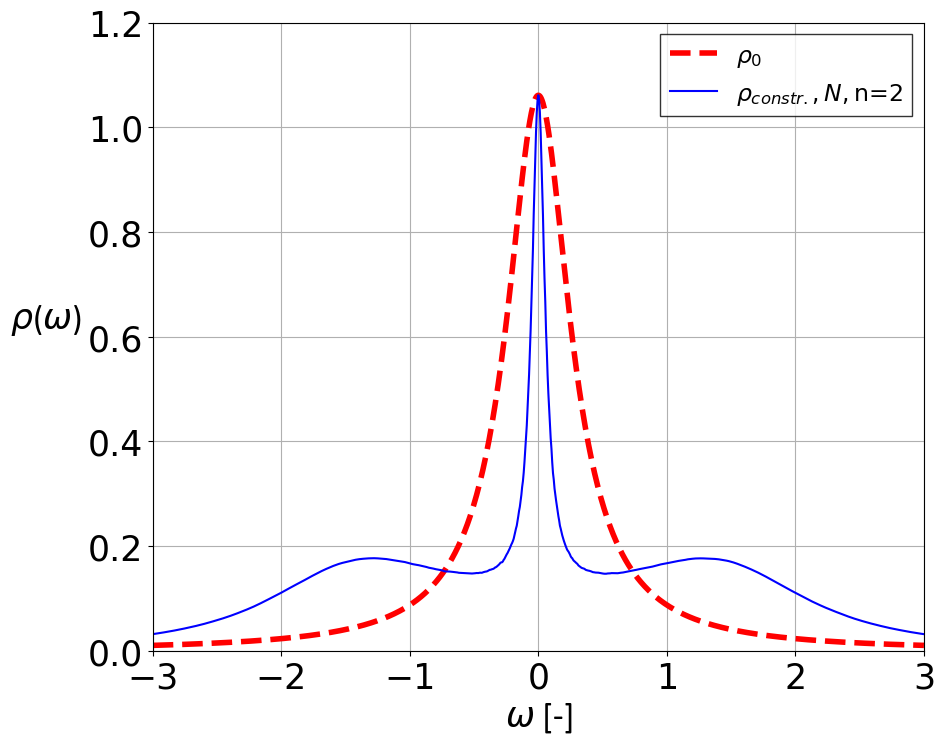

In [9]:
import DEDlib

nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=DEDlib.main(**{"N":4000000,"poles":2,"Ed":-3/2,"ctype":'n'})
DEDlib.DOSplot(fDOS,Lor,omega,'constraintN2p','$\\rho_{constr.},N,$n=2')
DEDlib.textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),fDOS,'constraintN2p')

Iterations:   0%|          | 0/20000 [00:00<?, ?it/s]

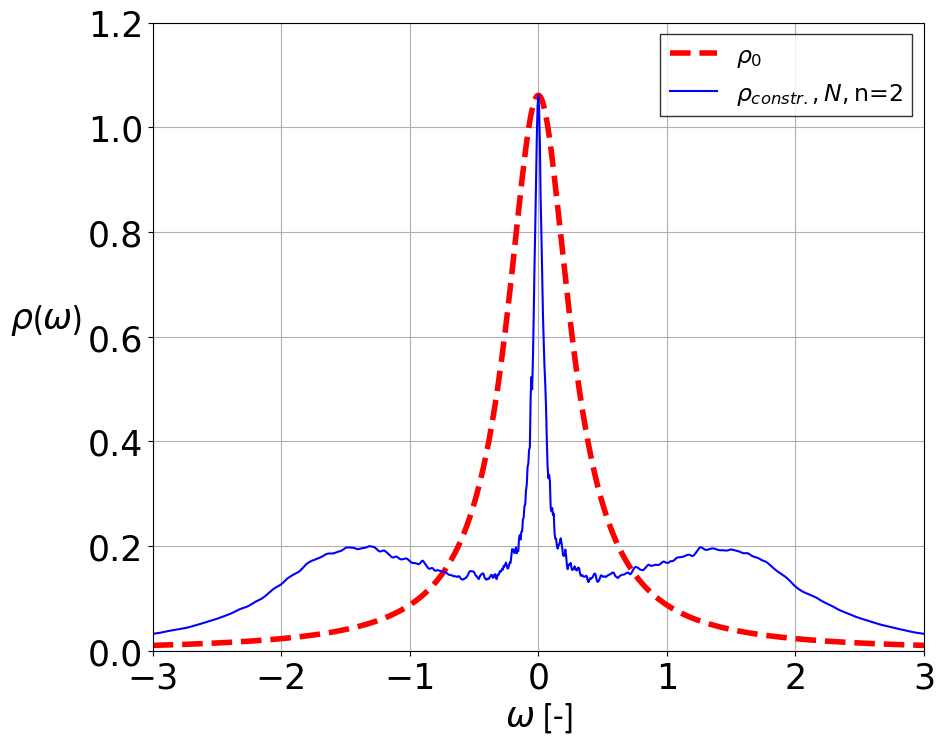

In [3]:
poles,Nit=4,20000
test=DEDlib(poles,Nit)
test.Nit
name,labels='constraintN4p','$\\rho_{constr.},N,$n=2'
plot=test.DOSplot(name,labels)

Iterations:   0%|          | 0/20000 [00:00<?, ?it/s]

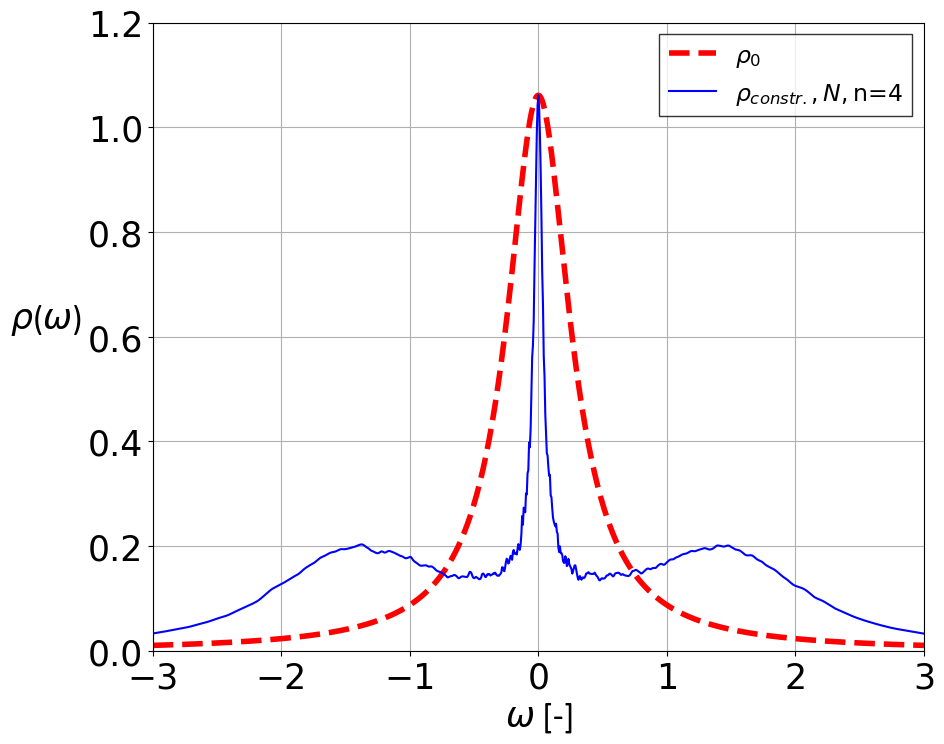

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [5]:
nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=DEDlib.main(**{"N":20000,"poles":4,"Ed":-3/2,"ctype":'n'})
DEDlib.DOSplot(fDOS,Lor,omega,'constraintN2p','$\\rho_{constr.},N,$n=4')

No. SAIM DED sims:   0%|          | 0/1 [00:00<?, ?it/s]

Iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

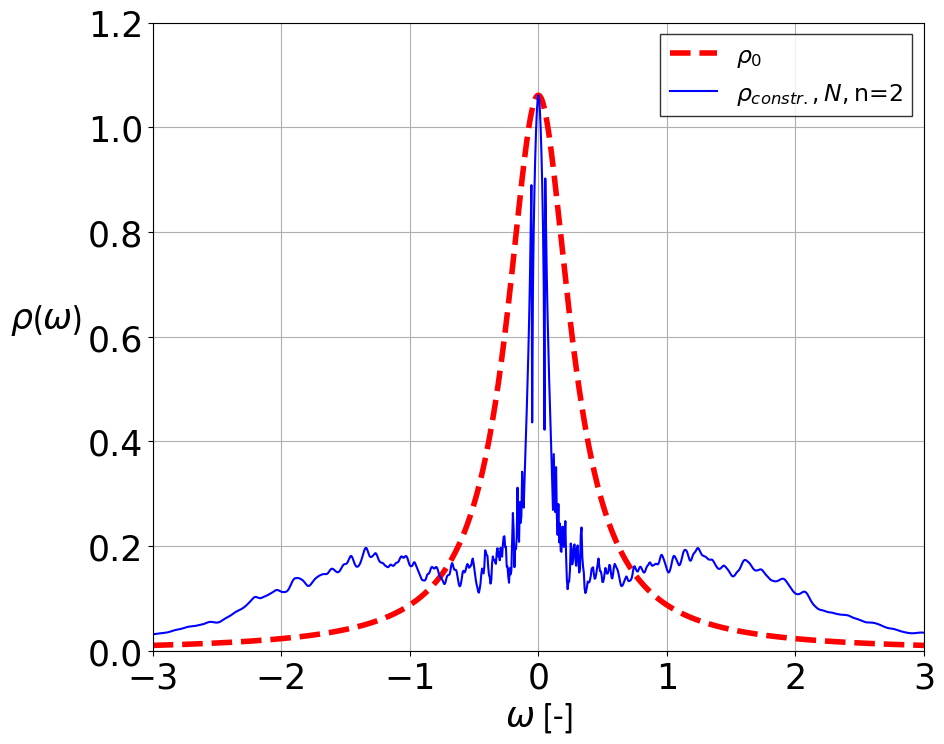

In [2]:
input=[{"N":2000,"poles":2,"Ed":-3/2,"ctype":'n'}]
filenames,labelnames=tqdm(['constraintN2p'],position=0,leave=False,desc='No. SAIM DED sims',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'),['$\\rho_{constr.},N,$n=2','$\\rho_{constr.},N,$n=3','$\\rho_{constr.},N,$n=4','$\\rho_{constr.},N,$n=5','$\\rho_{constr.},N,$n=6','$\\rho_{no constr.},$n=4','$\\rho_{constr.},$$N\\%$2,n=4']
for i,file in enumerate(filenames):
    nd,_,fDOS,Lor,omega,selectpT,selectpcT,tsim=main(**input[i])
    DOSplot(fDOS,Lor,omega,file,labelnames[i])
    textfileW(omega,np.ravel(selectpT),np.ravel(selectpcT),fDOS,file)
filenames.close()